In [1]:
use_gpu = True
data_dir = '/home/kartik/data'

In [2]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport alphagan

In [3]:
from collections import defaultdict
from psutil import cpu_count

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import init, Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# get a image data set into a tensor, scale to (-1, 1), discarding labels
def torchvision_dataset(dset_fn, train=True):
    dset = dset_fn(
        data_dir,
        train=train,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]),
        target_transform=None,
        download=True)
    return torch.stack(list(zip(*dset))[0])*2-1

In [5]:
cifar = torchvision_dataset(datasets.CIFAR10, train=True)
cifar_test = torchvision_dataset(datasets.CIFAR10, train=False)
print(cifar.size())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])


In [6]:
batch_size = 256

In [7]:
num_workers = cpu_count() if use_gpu else 0

X_train = DataLoader(cifar, batch_size=batch_size, shuffle=True,
                     num_workers=num_workers, pin_memory=use_gpu)
X_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=use_gpu)

In [8]:
class ChannelsToLinear(nn.Linear):
    """Flatten a Variable to 2d and apply Linear layer"""
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))

class LinearToChannels2d(nn.Linear):
    """Reshape 2d Variable to 4d after Linear layer"""
    def __init__(self, m, n, w=1, h=None, **kw):
        h = h or w
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)

class ResBlock(nn.Module):
    """Simple ResNet block"""
    def __init__(self, c,
                 activation=nn.LeakyReLU, norm=nn.BatchNorm2d,
                 init_gain=1, groups=1):
        super().__init__()
        self.a1 = activation()
        self.a2 = activation()
        self.norm1 = norm and norm(c)
        self.norm2 = norm and norm(c)
        
        to_init = []
        self.conv1 = nn.Conv2d(
            c, c, 3, 1, 1, bias=bool(norm), groups=groups)
        to_init.append(self.conv1.weight)            
        self.conv2 = nn.Conv2d(
            c, c, 3, 1, 1, bias=bool(norm), groups=groups)
        to_init.append(self.conv2.weight)
        
        # if using grouping, add a 1x1 convolution to each conv layer
        if groups!=1:
            self.conv1 = nn.Sequential(
                self.conv1, nn.Conv2d(c,c,1,bias=bool(norm)))
            self.conv2 = nn.Sequential(
                self.conv2, nn.Conv2d(c,c,1,bias=bool(norm)))
            to_init.extend([self.conv1[1].weight, self.conv2[1].weight])
                    
        # init
        for w in to_init:
            init.xavier_normal(w, init_gain)
        
    def forward(self, x):
        y = self.conv1(x)
        if self.norm1:
            y = self.norm1(y)
        y = self.a1(y)
        
        y = self.conv2(y)
        if self.norm2:
            y = self.norm2(y)
                
        return self.a2(x+y)

In [9]:
latent_dim = 128

In [10]:
# encoder network
h = 128
resample = nn.AvgPool2d
norm = None
a, g = nn.ReLU, init.calculate_gain('relu')
groups = 1#h//8
E = nn.Sequential(
    nn.Conv2d(3,h,5,1,2), resample(2), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups),
    ChannelsToLinear(h*16, latent_dim)
)
for layer in (0,8):
    init.xavier_normal(E[layer].weight, g)

t = Variable(torch.randn(batch_size,3,32,32))
assert E(t).size() == (batch_size,latent_dim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  from ipykernel import kernelapp as app


In [11]:
# generator network
h = 128
norm = None
a, g = nn.ReLU, init.calculate_gain('relu')
groups = 1#h//8
resample = lambda x: nn.Upsample(scale_factor=x)
G = nn.Sequential(
    LinearToChannels2d(latent_dim,h,4,4), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups),
    nn.Conv2d(h, 3, 1), nn.Tanh()
)
for layer in (0,9):
    init.xavier_normal(G[layer].weight, g)

t = Variable(torch.randn(batch_size,latent_dim))
assert G(t).size() == (batch_size,3,32,32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()


In [12]:
# discriminator network
h = 128
resample = nn.AvgPool2d
norm = None
a, g = lambda: nn.LeakyReLU(.2), init.calculate_gain('leaky_relu', .2)
groups = 1

D = nn.Sequential(
    nn.Conv2d(3,h,5,1,2), resample(2), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups), resample(2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups),
    ChannelsToLinear(h*16, 1)
)
for layer in (0,8):
    init.xavier_normal(D[layer].weight, g)
    
t = Variable(torch.randn(batch_size,3,32,32))
assert D(t).size() == (batch_size,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()


In [13]:
# code discriminator network
h = 700
a, g = lambda: nn.LeakyReLU(.2), init.calculate_gain('leaky_relu', .2)
C = nn.Sequential(
    nn.Linear(latent_dim, h), a(),
    nn.Linear(h, h), a(),
    nn.Linear(h, 1),
)

for i,layer in enumerate(C):
    if i%2==0:
        init.xavier_normal(layer.weight, g)

t = Variable(torch.randn(batch_size,latent_dim))
assert C(t).size() == (batch_size,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  if sys.path[0] == '':


In [14]:
model = alphagan.AlphaWGAN(E, G, D, C, latent_dim, lambd=40, z_lambd=0)
if use_gpu:
    model = model.cuda()

In [15]:
# model.load_state_dict(torch.load('../models/wgan_cifar10_dim_{}_lambda_{}_zlambd_{}_epochs_{}.torch'.format(
#         latent_dim, model.lambd, model.z_lambd, 4
#     )))

In [16]:
diag = []
def log_fn(d):
    d = pd.DataFrame(d)
    diag.append(d)
    print(d)

In [17]:
def checkpoint_fn(model, epoch):
    path =  '../models/wgan_cifar10_dim_{}_lambda_{}_zlambd_{}_epochs_{}.torch'.format(
        model.latent_dim, model.lambd, model.z_lambd, epoch
    )
    torch.save(model.state_dict(), path)

In [18]:
# %%prun
model.fit(
    X_train, X_test,
    n_iter=(1,5,5), n_epochs=4,
#     n_batches = (4,4),
    opt_params={'lr':1e-4, 'betas':(.5,.9)},
    log_fn=log_fn, log_every=1,
    checkpoint_fn=checkpoint_fn, checkpoint_every=1
)

                           train      valid
C_critic_loss         -11.635004 -10.350653
C_gradient_penalty      1.797975   1.493553
D_critic_loss          -7.661589  -8.402270
D_gradient_penalty      1.372621   1.034688
adversarial_loss       12.419829 -23.905209
code_adversarial_loss  -1.995974  -2.857663
reconstruction_loss    12.614973  10.779352


                           train      valid
C_critic_loss          -7.835329  -5.764362
C_gradient_penalty      0.969838   0.641884
D_critic_loss          -6.740700  -6.349144
D_gradient_penalty      0.869746   0.800640
adversarial_loss      -17.107382 -13.858475
code_adversarial_loss  -3.019807  -2.708389
reconstruction_loss    11.212499  11.201015


                           train      valid
C_critic_loss          -4.866635  -4.289764
C_gradient_penalty      0.467750   0.383844
D_critic_loss          -4.816281  -4.687969
D_gradient_penalty      0.509644   0.503710
adversarial_loss       -3.229794  -2.691923
code_adversarial_loss  -1.526694  -0.972477
reconstruction_loss    10.788114  10.287782


                           train      valid
C_critic_loss          -3.872909  -3.695042
C_gradient_penalty      0.341297   0.309088
D_critic_loss          -3.967117  -3.753757
D_gradient_penalty      0.380238   0.389384
adversarial_loss       -0.667429  -0.309710
code_adversarial_loss  -0.635379  -0.464543
reconstruction_loss    10.150286  10.221409



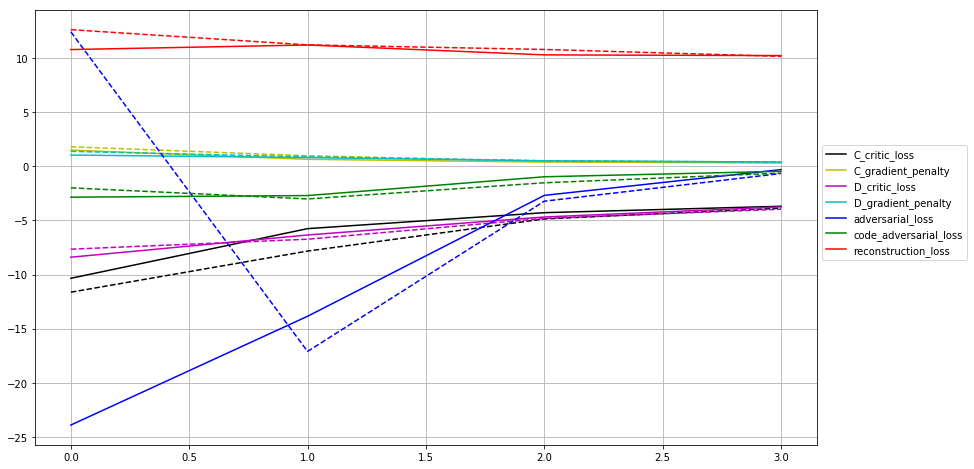

In [19]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
diagnostic = pd.concat([pd.DataFrame(d.stack(), columns=[i]).T for i,d in enumerate(diag)])
cols = list('rgbcmyk')
colors = defaultdict(lambda: cols.pop())
for c in diagnostic:
    component, dataset = c
    kw = {}
    if dataset=='valid':
        kw['label'] = component
    else:
        kw['ls'] = '--'
    ax.plot(diagnostic[c].values, c=colors[component], **kw)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.grid(True)

In [20]:
model.eval()
pass

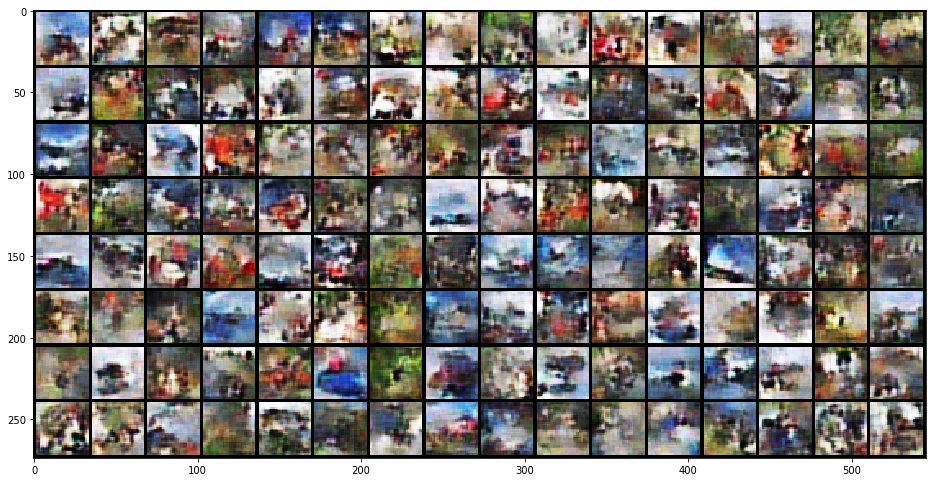

In [21]:
# samples
z, x = model(128, mode='sample')
fig, ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(make_grid(
    x.data, nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

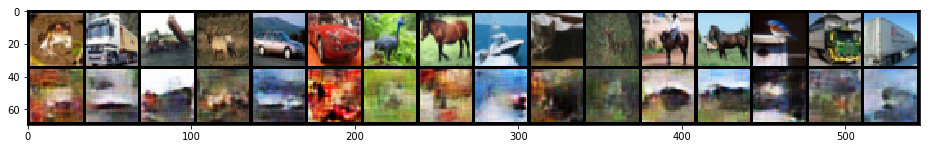

In [22]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# training reconstructions
x = cifar[:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

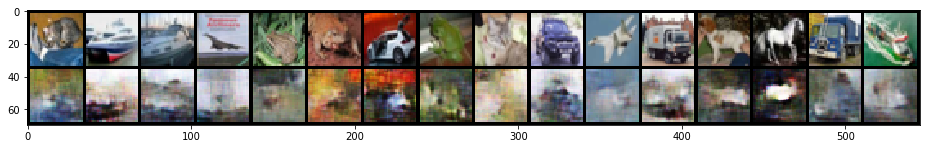

In [23]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# test reconstructions
x = cifar_test[:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

pairwise distances give a sense of how encoded z are distributed compared to samples from the prior:

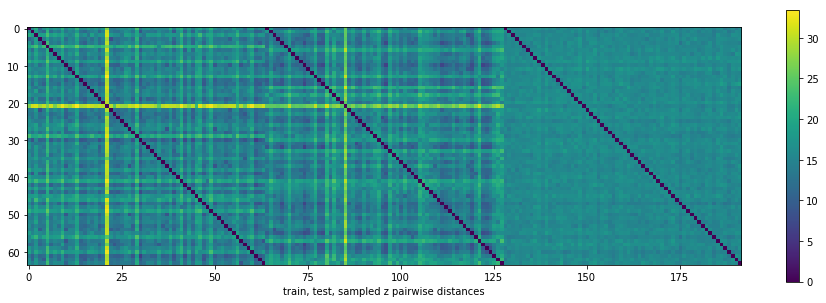

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,5))
n = 64

import scipy.spatial
train_z = model(cifar[:n], mode='encode').data.cpu().numpy()
test_z = model(cifar_test[:n], mode='encode').data.cpu().numpy()
sampled_z = model.sample_prior(n).data.cpu().numpy()
train_cdist = scipy.spatial.distance.cdist(train_z,train_z)
test_cdist = scipy.spatial.distance.cdist(test_z,test_z)
sampled_cdist = scipy.spatial.distance.cdist(sampled_z,sampled_z)
cax = ax.imshow(np.concatenate((train_cdist, test_cdist, sampled_cdist),1))
fig.colorbar(cax)
ax.set_xlabel('train, test, sampled z pairwise distances')
pass

### Interpolation

In [25]:
def slerp(z0, z1, t):
    """Spherical linear interpolation over last dimension:
    z0.shape = z1.shape = (m,...n, d) and t.shape = (q,) -> (q, m,...n, d)
    Project to unit sphere and linearly interpolate magnitudes.
    """
    m0, m1 = (np.linalg.norm(z, 2, -1) for z in (z0, z1))
    p0, p1 = z0/np.expand_dims(m0,-1), z1/np.expand_dims(m1,-1)
    omega = np.arccos((p0*p1).sum(-1))
    while t.ndim<=omega.ndim:
        t = np.expand_dims(t,-1)
    sin_omega = np.sin(omega)
    t0 = np.sin((1-t)*omega)/sin_omega
    t1 = np.sin(t*omega)/sin_omega
    lim = abs(omega)<1e-15
    t1[lim] = t[lim]
    t0[lim] = (1-t)[lim]
    t0, t1 = np.expand_dims(t0, -1), np.expand_dims(t1, -1)
    m = np.expand_dims((1-t)*m0 + t*m1, -1)
    return m*(t0*p0 + t1*p1)
def slerp4(z, t):
    # z (4,n) and t (m,) -> z' (m, m, n)
    return slerp(
        slerp(z[0], z[1], t),
        slerp(z[2], z[3], t),
        t)

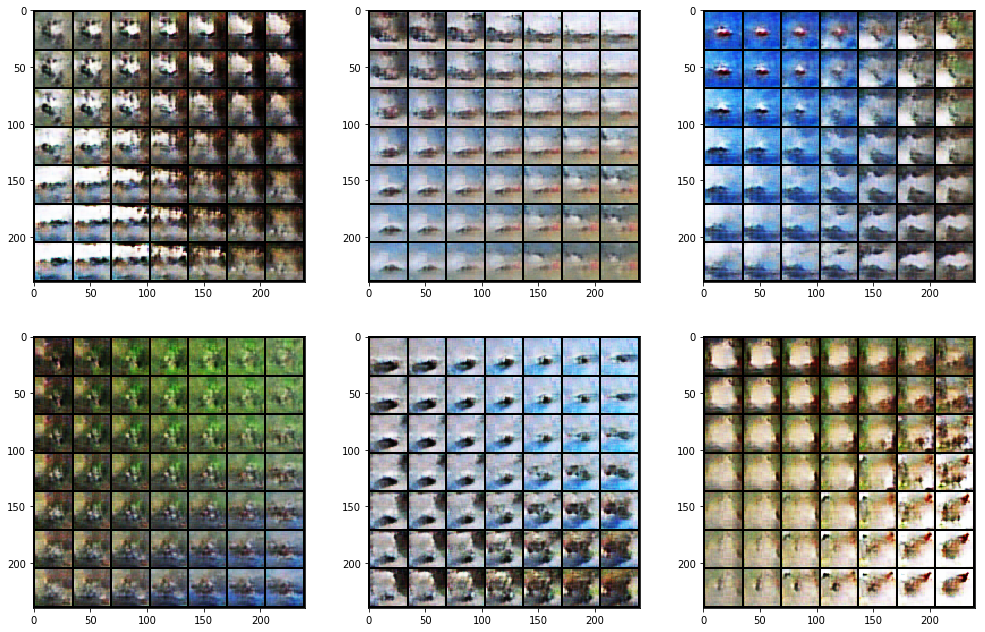

In [27]:
n = 7
fig,ax = plt.subplots(2,3,figsize=(17,11))
for ax in ax.flatten():
    x = cifar_test[torch.LongTensor(np.random.randint(len(cifar_test),size=4))]
    z = model(x, mode='encode')
    z = slerp4(z.data.cpu().numpy(), np.linspace(0,1,n)).reshape(n*n,-1)
    x_rec = model(z, mode='generate')
    ax.imshow(make_grid(
        x_rec.cpu().data, nrow=n, range=(-1,1), normalize=True
    ).numpy().transpose(1,2,0), interpolation='nearest')